# Imports 

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
import numpy as np 
import os 
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
!pip uninstall -y kaggle 
!pip install kaggle==1.5.6
%env KAGGLE_USERNAME =thesniper
%env KAGGLE_KEY =f5a849dfb011d6d68a526d96bdac49a3

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=6d0dd6d4cc13dbeb7c0d687bb999bb52cc78b8495a8599fbaf6bb90503b90e6e
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
env: KAGGLE_USERNAME=thesniper
env: KAGGLE_KEY=f5a849dfb011d6d68a526d96bdac49a3


# Model Architecture 
Replicate the Architecture of C3D Model 

In [0]:
def create_model_sequential():
    """ Creates model object with the sequential API:
    https://keras.io/models/sequential/
    """

    model = Sequential()
    input_shape = (16, 112, 112, 3)

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                     padding='same', name='conv1',
                     input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    return model

def create_features_exctractor(C3D_model, layer_name='fc7'):
    extractor = Model(inputs=C3D_model.input,
                      outputs=C3D_model.get_layer(layer_name).output)
    return extractor

# Create Model and Load Weights 


In [0]:
model = create_model_sequential()

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
 model.load_weights('/content/gdrive/My Drive/C3D_Sport1M_weights_keras_2.2.4.h5')

# Test For Model

In [0]:
model = create_features_exctractor(model)
new_model = model.output
new_model = Dense(5, activation="softmax")(new_model)
model = Model(inputs=model.input, outputs=new_model)

In [0]:
for layer in model.layers:
    layer.trainable = False

model.layers[-1].trainable = True

In [0]:
map = {
	'Diving' :	0,
	'Jumping' :	1,
	'Basketball':	2,
	'Tennis':	3,
	'Walking':	4}
classes = ['Diving',
	'Jumping',
	'Basketball',
	'Tennis',
	'Walking']

In [0]:
path = '/content/gdrive/My Drive/vision project/Training'
data=[]
labels=[]
for folder in os.listdir(path):
    print(folder)
    ctr0 = 0 
    ctr1 = 0 
    for video in os.listdir(os.path.join(path,folder)):
        frames=[]
        cap=cv2.VideoCapture(path+'/'+folder+'/'+video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        while(True):
              ret, frame = cap.read()
              if frame is None : 
                 break
              frame=cv2.resize(frame,(112,112))
              frames.append(frame)
        for i in range(0,np.shape(frames)[0],10):
           if i+16 < np.shape(frames)[0]:
              data.append(frames[i:i+16])
              labels.append(map[folder])
    print(np.shape(data))       


Basketball
(1127, 16, 112, 112, 3)
Tennis
(2747, 16, 112, 112, 3)
Diving
(4537, 16, 112, 112, 3)
Jumping
(6476, 16, 112, 112, 3)
Walking
(7946, 16, 112, 112, 3)


In [0]:
labels = np.reshape(labels,(np.shape(labels)[0],1))
data = np.array(data)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.1,stratify=labels,random_state=42,shuffle=True)

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
y_train[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [0]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
callbacks=reduce_learning_rate

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 2 , batch_size=32 , shuffle=True, callbacks=[callbacks,checkpoint])

Train on 7151 samples, validate on 795 samples
Epoch 1/2
7151/7151 [==============================] - 335s 47ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0087 - val_accuracy: 0.9975

Epoch 00001: loss improved from inf to 0.05518, saving model to best_model.hdf5
Epoch 2/2
7151/7151 [==============================] - 320s 45ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0044 - val_accuracy: 0.9987

Epoch 00002: loss improved from 0.05518 to 0.00636, saving model to best_model.hdf5


# Confusion Matrix 

            Diving  Jumping  Basketball  Tennis  Walking
Diving         179        0           0       0        0
Jumping          0      194           0       0        0
Basketball       0        0         113       0        0
Tennis           0        0           0     162        0
Walking          0        0           1       0      146


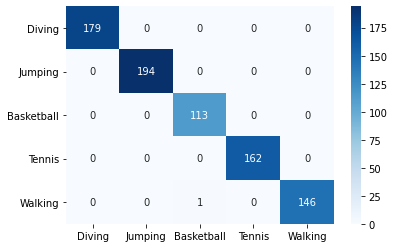

In [0]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import seaborn as sn

#y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred,axis=1)
cm =confusion_matrix(np.argmax(y_test,axis=1), y_pred).tolist()
cm =  pd.DataFrame(cm, index=classes, columns=classes)
print(cm)
ax = sn.heatmap(cm, cmap='Blues', annot=True,fmt="d")

In [0]:
model.fit(data,to_categorical(labels),batch_size=32,epochs = 2 , shuffle=True)

Epoch 1/2
7946/7946 [==============================] - 77s 10ms/step - loss: 0.0042 - accuracy: 0.9994
Epoch 2/2
7946/7946 [==============================] - 77s 10ms/step - loss: 0.0018 - accuracy: 1.0000


In [0]:
test_path = '/content/gdrive/My Drive/vision project/Testing'
lab =[]
names=[]
for video in os.listdir(test_path):
        frames=[]
        cap=cv2.VideoCapture(test_path+'/'+video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        while(True):
              ret, frame = cap.read()
              if frame is None : 
                 break
              frame=cv2.resize(frame,(112,112))
              frames.append(frame)
        prds = np.zeros((5,1))
        for i in range(0,np.shape(frames)[0],10):
           if i+16 < np.shape(frames)[0]:
             prd = model.predict(np.reshape(frames[i:i+16],(1,16,112,112,3)))
             prd = np.argmax(prd)
             prds[prd]+=1
        print(np.argmax(prds))
        print(video)
        lab.append(np.argmax(prds))
        names.append(video)
              
        

3
test_image (88).mpg
3
test_image (89).mpg
3
test_image (90).mpg
3
test_image (91).mpg
3
test_image (92).mpg
3
test_image (93).mpg
3
test_image (94).mpg
3
test_image (95).mpg
3
test_image (97).mpg
3
test_image (98).mpg
3
test_image (96).mpg
3
test_image (100).mpg
3
test_image (99).mpg
3
test_image (101).mpg
3
test_image (103).mpg
3
test_image (102).mpg
3
test_image (105).mpg
3
test_image (104).mpg
3
test_image (106).mpg
3
test_image (87).mpg
1
test_image (33).mpg
1
test_image (34).mpg
1
test_image (35).mpg
1
test_image (36).mpg
1
test_image (37).mpg
1
test_image (38).mpg
1
test_image (39).mpg
1
test_image (40).mpg
1
test_image (41).mpg
1
test_image (44).mpg
1
test_image (43).mpg
1
test_image (42).mpg
1
test_image (46).mpg
1
test_image (45).mpg
1
test_image (47).mpg
1
test_image (48).mpg
1
test_image (49).mpg
1
test_image (32).mpg
1
test_image (51).mpg
1
test_image (50).mpg
4
test_image (108).mpg
4
test_image (109).mpg
4
test_image (110).mpg
4
test_image (111).mpg
4
test_image (112).mp

In [0]:
df = pd.DataFrame(list(zip(names, lab)), 
               columns =['Video', 'Label']) 

In [0]:
df.to_csv('submission.csv',index=False)
!kaggle competitions submit computervisioncompetitionsc2020 -f "submission.csv" -m "Submission from API"

100% 2.74k/2.74k [00:06<00:00, 401B/s]
Successfully submitted to Computer Vision Competition [SC-2020]

In [0]:
model.save('/content/gdrive/My Drive/vision project/submission2.h5')